In [ ]:
!pip install torch transformers

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd

In [2]:
# CSV dosyasını yükle
df = pd.read_csv("/content/drive/My Drive/tweets.csv")

In [3]:
# TurkishBert modelii yükle
model_name = "savasy/bert-base-turkish-sentiment-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to('cpu')  # GPU'ya taşıyın

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

In [4]:
# Güncellenmiş Sentiment Tahmini Fonksiyonu
def predict_sentiment(text):
    # Metni tokenizer ile işleme
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    ).to('cpu')  # Veriyi GPU'ya taşıyın

    # Modelden çıktılar
    outputs = model(**inputs)

    # Logit değerlerini softmax ile olasılığa dönüştürme
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # En yüksek olasılığa sahip etiketi seçme
    sentiment = torch.argmax(probabilities).item()

    # Etiketlere göre duygu sınıflandırması
    if sentiment == 0:
        return "negative"
    elif sentiment == 1:
        return "neutral"
    elif sentiment == 2:
        return "positive"


In [6]:
import re
import string

# Tweet ön işleme fonksiyonu
def preprocess_text(text):
    if not isinstance(text, str):
        return ""  # Geçersiz girişleri boş string ile değiştir

    # 1. URL'leri kaldır
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # 2. Kullanıcı etiketlerini (@kullanıcı) kaldır
    text = re.sub(r"@\w+", "", text)

    # 3. Hashtag (#etiket) işaretini kaldır ama etiketi koru
    text = re.sub(r"#", "", text)

    # 4. Emojileri kaldır
    text = re.sub(r"["
                  u"\U0001F600-\U0001F64F"  # Smileys
                  u"\U0001F300-\U0001F5FF"  # Semboller ve Piktogramlar
                  u"\U0001F680-\U0001F6FF"  # Ulaşım ve Haritalar
                  u"\U0001F1E0-\U0001F1FF"  # Bayraklar
                  u"\U00002702-\U000027B0"  # Çeşitli Semboller
                  u"\U000024C2-\U0001F251"  # Diğer Semboller
                  "]+", "", text)

    # 5. Noktalama işaretlerini kaldır
    text = text.translate(str.maketrans("", "", string.punctuation))

    # 6. Sayıları kaldır
    text = re.sub(r"\d+", "", text)

    # 7. Fazla boşlukları temizle
    text = re.sub(r"\s+", " ", text).strip()

    # 8. Küçük harfe çevir
    text = text.lower()

    return text


# NaN değerlerini boşlukla doldur ve satırları çıkar
df['text'] = df['text'].fillna('')

# Verilerdeki NaN satırları çıkar
df = df[df['text'] != '']

# Her tweet için etiket oluştur
print("Tweetlerin etiketlenmesi başlıyor...")
df['sentiment'] = df['text'].apply(predict_sentiment)

# Etiketlenmiş CSV'yi kaydet
output_file = "/content/drive/My Drive/savasy_bert-base-turkish-sentiment-cased_labeled.csv"
df.to_csv(output_file, index=False)
print(f"Etiketleme tamamlandı. Yeni dosya: {output_file}")

# Etiketlenmiş dosyayı indirme
from google.colab import files
files.download(output_file)


Tweetlerin etiketlenmesi başlıyor...
Etiketleme tamamlandı. Yeni dosya: /content/drive/My Drive/savasy_bert-base-turkish-sentiment-cased_labeled.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

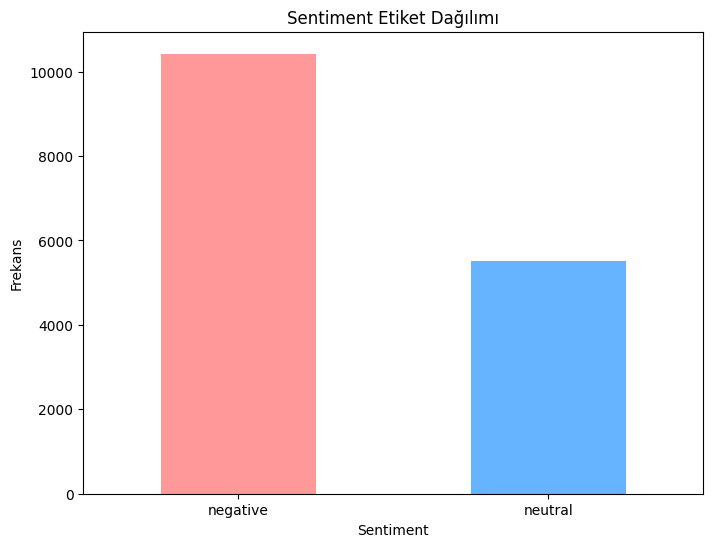

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# CSV dosyasını yükleme
labeled_data_file = "/content/drive/My Drive/savasy_bert-base-turkish-sentiment-cased_labeled.csv"
df = pd.read_csv(labeled_data_file)

# Etiket dağılımını hesaplama
sentiment_counts = df['sentiment'].value_counts()

# Çubuk grafik oluşturma
plt.figure(figsize=(8, 6))
sentiment_counts.plot.bar(color=['#ff9999', '#66b3ff', '#99ff99'])
plt.title("Sentiment Etiket Dağılımı")
plt.xlabel("Sentiment")
plt.ylabel("Frekans")
plt.xticks(rotation=0)  # X eksenindeki etiketleri yatay tut
plt.show()
